In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Machine leraning machines
import sklearn
from sklearn.linear_model import LogisticRegression

# Import nltk for language processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Predicting Amazon review scores

Can we predict whether a user will leave a positive or negative review based simply on what they have to say? In theory, we should be able to see some sort of correlation between negative reviews and their choice of words. To evaluate a case study, we'll be taking a look at Amazon review scores from May 1996 - July 2014, specifically their electronics division.

In [2]:
# Grab and process the raw data.
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Data\\reviews_Electronics_5.json.gz')

In [3]:
# Prints first 5 rows in our dataframe
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [4]:
# Drop all null values in our dataframe
df = df.dropna()

# Data cleaning
df['summary'] = df['summary'].str.lower()
df['summary'] = df['summary'].str.replace('[^\w\s]','')
df['summary'] = df['summary'].str.strip()

# Import our list of stopwords
stop = stopwords.words('english')

# Remove stopwords from the reviews
X = pd.DataFrame()
X['summary'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Creating our outcome series
Y = df['overall']

In [5]:
# Prints the dimensions of our dataframe
df.shape

(1664458, 9)

So, if you look at the size of our dataset, you can see that that there are roughly 1.66 million reviews and 9 columns for electronics purchased on Amazon. Now, our dataset will require a bit of preparation before we can use it for our model. The only column that we really need for creating our model will be our 'reviewText' column, which contains what people had to say in their reviews. We will also need our 'overall' column, as that is the review score that we want to predict. As for everything else, while they may help assist us in predicting review scores, the challenge of this assignment is to rely only on text data, so we will be dropping them from our dataset.

C:\Users\nu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


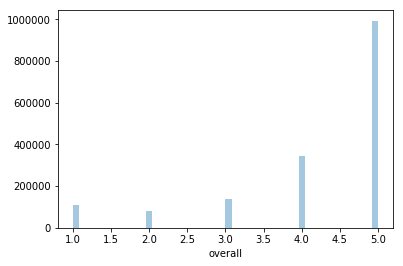

In [6]:
# Plot distribution of review scores
sns.distplot(Y, kde=False)

Based on the distribution of review scores above, we can see that people that review products tend to leave very positive reviews. Since we want to have roughly equal groups in both of our outcomes, we'll have to revise what our definition of a good and bad review are.

C:\Users\nu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


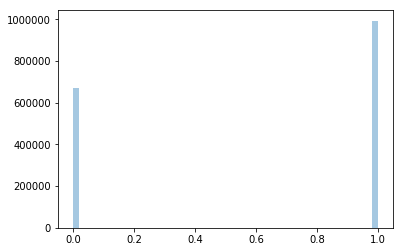

In [7]:
# Let's combine all values lower than 5 into a single value
Y = np.where(Y > 4, 1, 0)

# Plots 1-4 star reviews against 5 star reviews
sns.distplot(Y, kde=False)

If we decide that positive reviews are only perfect 5 star reviews, and everything else (1-4) is an imperfect review, we have enough entries for both outcomes, so we can proceed with the model.

In [8]:
# Count 50 most common word / word combinations
pop_words = X['summary'].value_counts().head(50)
pop_words

works great          19850
works                14500
great                14013
great product        12945
love                 12554
good                  9362
perfect               9264
nice                  7290
works well            7151
awesome               7001
good product          6553
excellent             6173
job                   6051
five stars            4788
far good              4778
ok                    4314
great price           3999
works fine            3884
great value           3861
works advertised      3782
great case            3634
                      3588
needed                3319
excellent product     3223
good price            2766
works perfectly       2618
amazing               2536
work                  2496
great buy             2483
good value            2438
wow                   2396
like                  2354
bad                   2220
great camera          2079
works expected        2030
expected              2006
get pay               1977
o

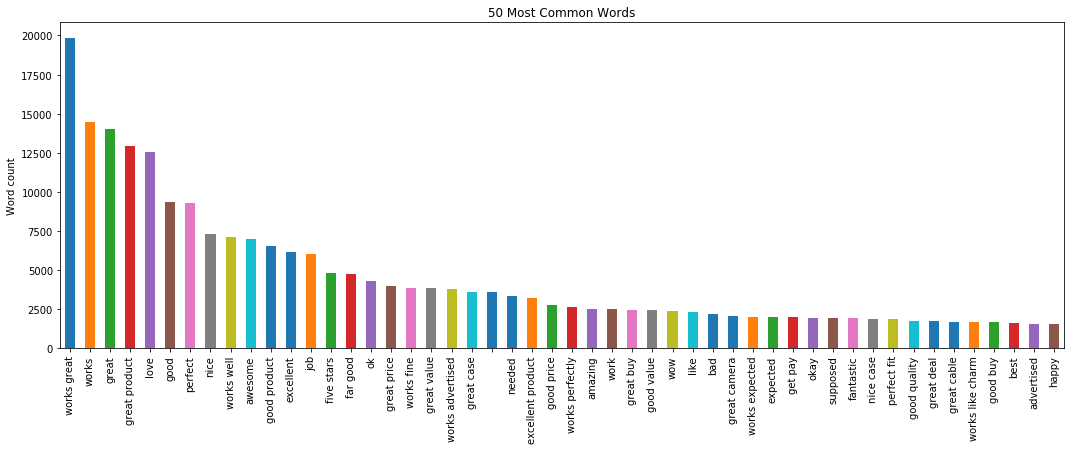

In [13]:
# Visualize our 50 most common word / word combinations
plt.rcParams['figure.figsize'] = [18,6]
plt.title('50 Most Common Words')
plt.ylabel('Word count')
pop_words.plot.bar()

In [10]:
X = X.append(pd.DataFrame(columns = pop_words.index))
X.head(10)

C:\Users\nu\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,,advertised,amazing,awesome,bad,best,excellent,excellent product,expected,fantastic,...,work,works,works advertised,works expected,works fine,works great,works like charm,works perfectly,works well,wow
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#X2 = X.sample(frac=0.01, replace=True)

In [12]:
# for index, row in X2.iterrows():
#     for item in list(X2):
#        if item in X2['summary']:
#            X2[index][item] = 1
#        else:
#            X2[index][item] = 0

KeyError: 200520

In [ ]:
# Selects the 10 best features in our dataset
# b = SelectKBest(f_classif, k=50)
# X_train = b.fit_transform(X, Y)

# Source

Amazon review data - electronics
http://jmcauley.ucsd.edu/data/amazon/